In [1]:
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
from PIL import Image
from scipy import misc
from scipy import ndimage

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load images & generate rescales

In [75]:
imagename = 'data/template.jpg'
k = np.sqrt(2)

#s = 3
#k = 2 ** (1.0 / s)

In [107]:
def image2nparray(img):
    return np.asarray(img,dtype='float64')/255.
    
def load_gray(imagename):
    img = Image.open(imagename).convert('L')
    h, w = img.size
    
    scaled_imgs = {}
    scaled_imgs[2] = img.resize((2*h, 2*w), resample = Image.BILINEAR)
    scaled_imgs[1] = scaled_imgs[2].resize((h, w), resample = Image.BILINEAR)
    scaled_imgs[0.5] = scaled_imgs[1].resize((h//2, w//2), resample = Image.BILINEAR)
    scaled_imgs[0.25] = scaled_imgs[0.5].resize((h//4, w//4), resample = Image.BILINEAR)
    scaled_imgs = {k:image2nparray(v) for k, v in scaled_imgs.items()}

    return image2nparray(img), scaled_imgs

def show_gray(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

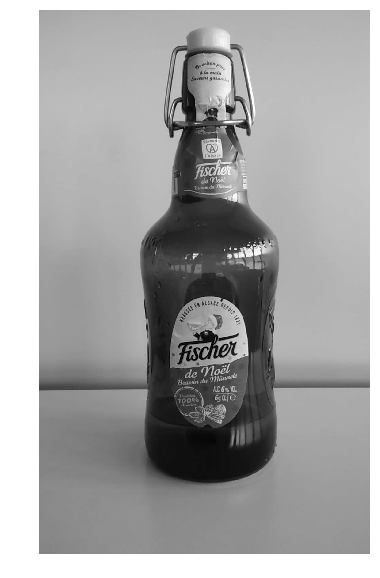

In [108]:
img, scaled_imgs = load_gray(imagename)
show_gray(img)

## Sigmas for gaussian filter

In [109]:
kvec1 = np.array([1.3, 1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4)])
kvec2 = np.array([1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7)])
kvec3 = np.array([1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10)])
kvec4 = np.array([1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11), 1.6 * (k ** 12), 1.6 * (k ** 13)])
kvectotal = np.array([1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11)])

sigmas = [kvec1,kvec2,kvec3,kvec4]

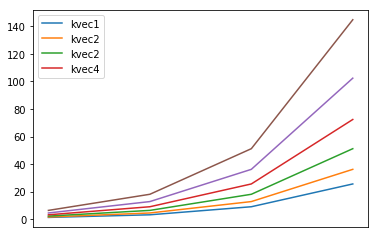

In [110]:
plt.plot(sigmas)
plt.legend(['kvec1', 'kvec2' ,'kvec2','kvec4'])
plt.xticks([])
plt.show()

## Applying Gaussian Filters

In [111]:
h, w = img.shape
octaves = [np.zeros((int(scale*h), int(scale*w), 6)) for scale in scaled_imgs.keys()]

In [112]:
for i in range(0, 6):
    octaves[0][:,:,i] = ndimage.filters.gaussian_filter(scaled_imgs[2], sigmas[0][i]) 
    octaves[1][:,:,i] = misc.imresize(ndimage.filters.gaussian_filter(scaled_imgs[2], sigmas[1][i]), 50, 'bilinear')/255.
    octaves[2][:,:,i] = misc.imresize(ndimage.filters.gaussian_filter(scaled_imgs[2], sigmas[2][i]), 25, 'bilinear')/255.
    octaves[3][:,:,i] = misc.imresize(ndimage.filters.gaussian_filter(scaled_imgs[2], sigmas[3][i]), 1.0 / 8.0, 'bilinear')/255.

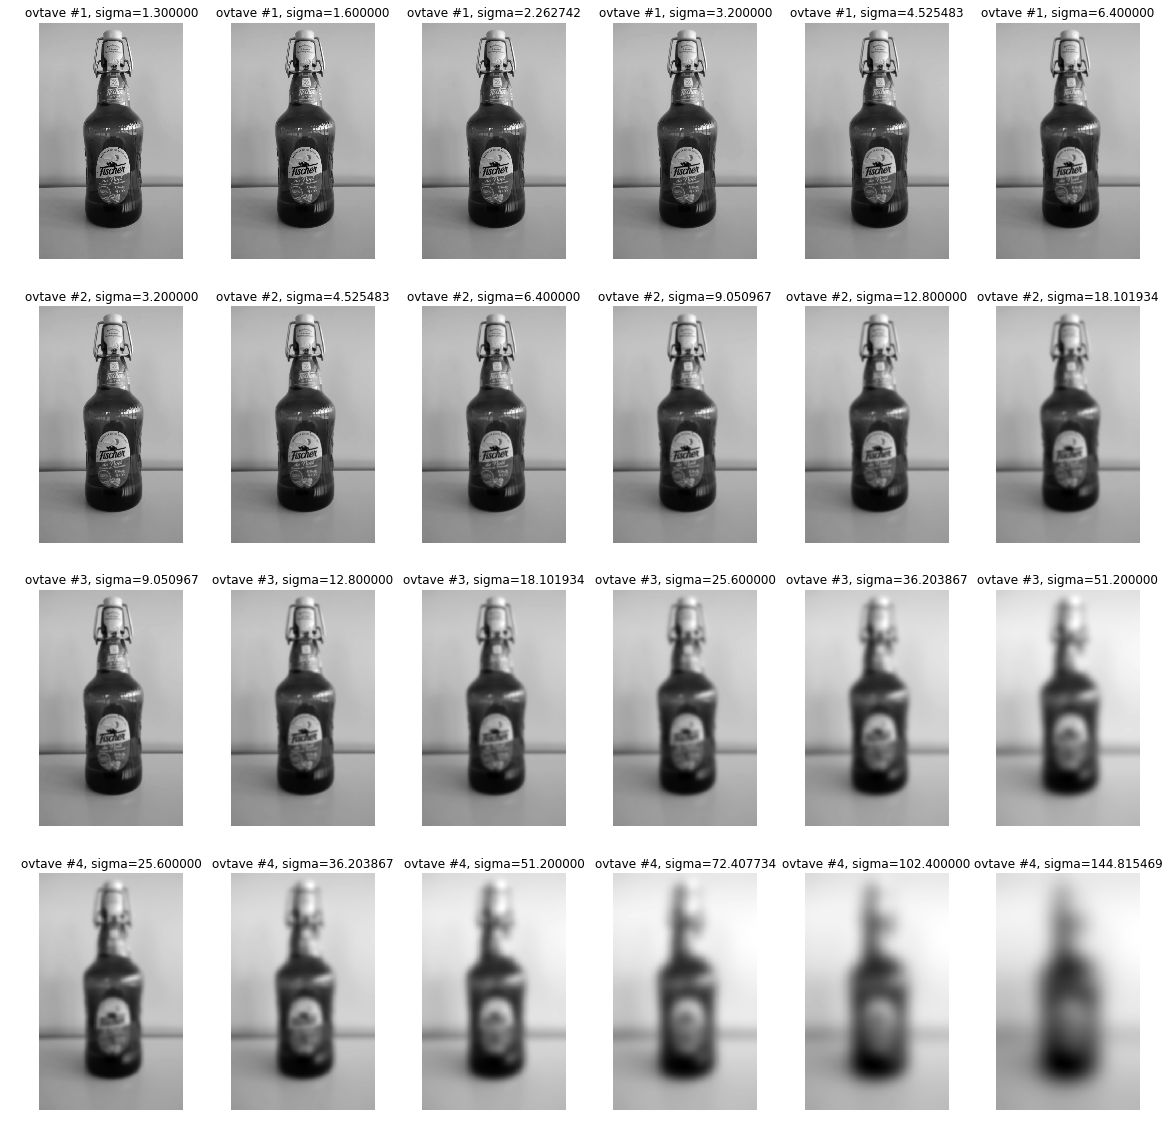

In [113]:
plt.figure(figsize=(20,20))
for lvl in range(4):
    for i in range(6):
        plt.subplot(4,6,i+ 6*lvl +1)
        plt.imshow(octaves[lvl][:,:,i],cmap='gray')
        plt.title('ovtave #%d, sigma=%2f' %(lvl+1, sigmas[lvl][i]))
        plt.axis('off')
plt.show()

## Computing DoG pyramids

In [114]:
dog = [np.diff(octave,axis=-1) for octave in octaves]

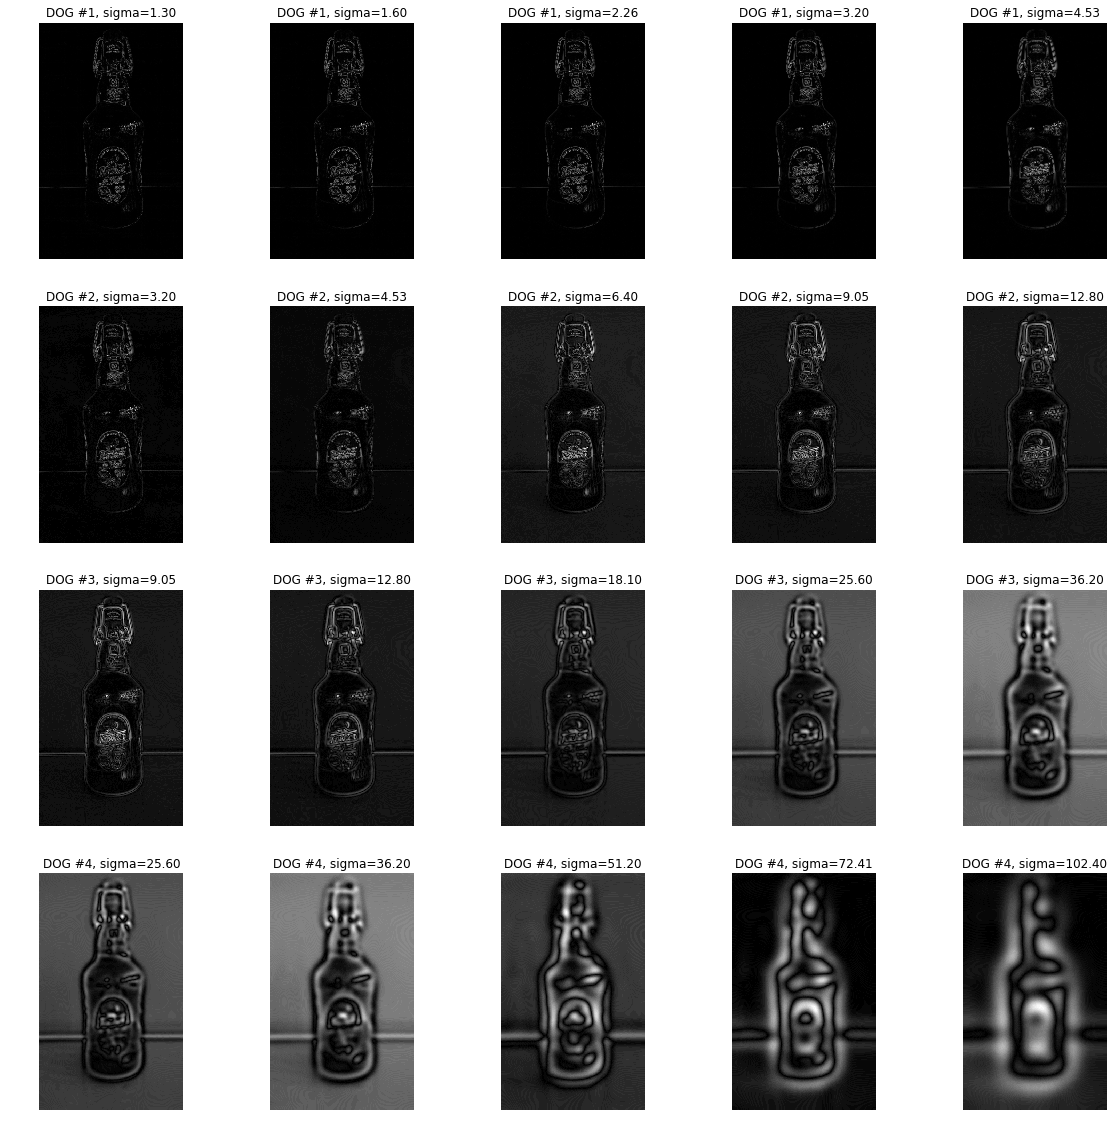

In [115]:
plt.figure(figsize=(20,20))
for lvl in range(4):
    for i in range(5):
        plt.subplot(4,5,i+ 5*lvl +1)
        plt.imshow(abs(dog[lvl][:,:,i]),cmap='gray')
        plt.title('DOG #%d, sigma=%.2f' %(lvl+1, sigmas[lvl][i]))
        plt.axis('off')
plt.show()

## Extrema detection
In each of the following for loops, elements of each pyramids that are larger or smaller than its 26 immediate neighbors in space and scale are labeled as extrema. As explained in section 4 of Lowe's paper, these initial extrema are pruned by checking that their contrast and curvature are above certain thresholds. The thresholds used here are those suggested by Lowe. 

### Finding the threshold

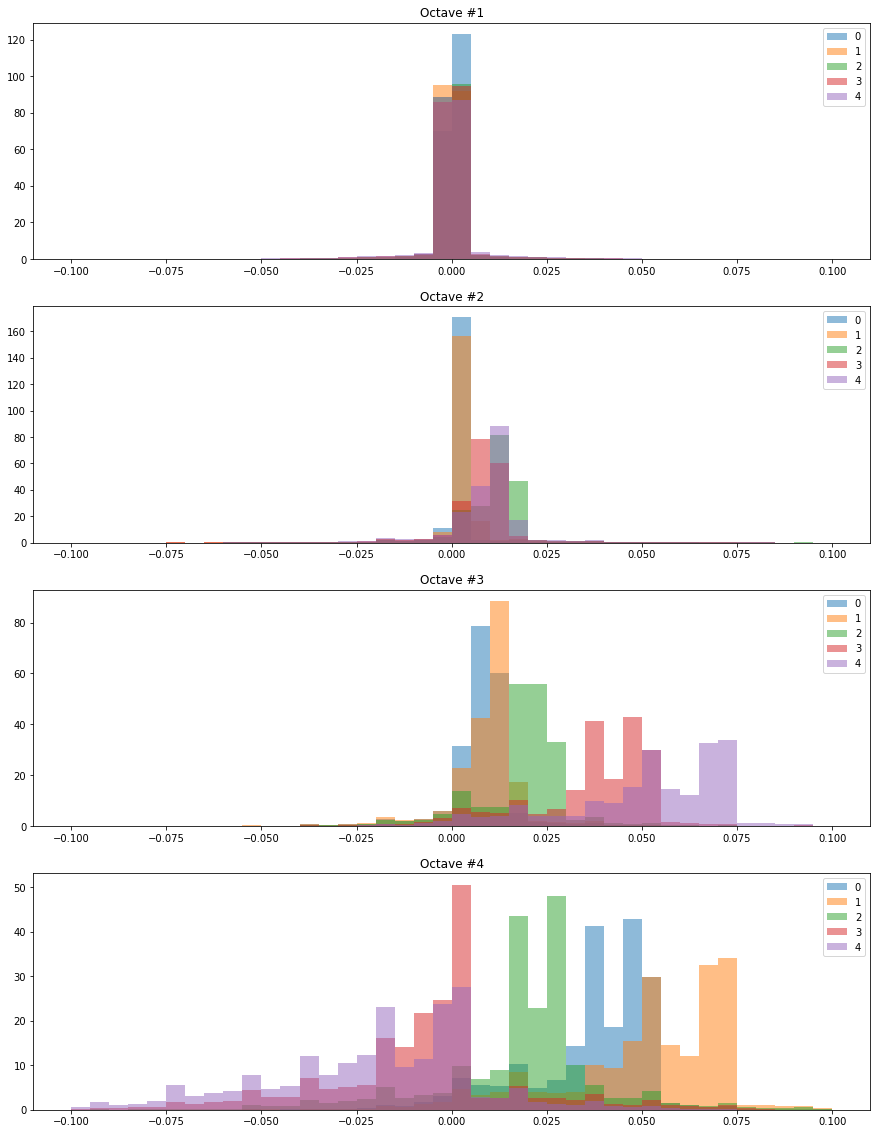

In [116]:
plt.figure(figsize=(15,20))
for i in range(4):
    plt.subplot('41%d' %(i+1))
    for j in range(5):
        plt.hist(dog[i][:,:,j].reshape(-1), bins = 40 , range = (-0.1, 0.1), label = '%d'%j, normed = True, alpha = 0.5) 
    plt.legend()
    plt.title('Octave #%d' %(i+1))
plt.show()

In [117]:
threshold = 0.03

In [118]:
def keypoints(octave_dogs, threshold = 0.03, r = 10.0, x_hat_thresh = 0.5):
    xextr, yextr, dxextr, dyextr, maskextr  = [], [], [], [], []
    h, w = octave_dogs.shape[:2]
    for i in range(1,octave_dogs.shape[2]-1):
        for j in range(80, h - 80):
            for k in range(80, w - 80):
                if np.absolute(octave_dogs[j, k, i]) < threshold:
                    continue

                maxbool = (octave_dogs[j, k, i] > 0)
                minbool = (octave_dogs[j, k, i] < 0)

                for di in range(-1, 2):
                    for dj in range(-1, 2):
                        for dk in range(-1, 2):
                            if di == 0 and dj == 0 and dk == 0:
                                continue

                            maxbool = maxbool and (octave_dogs[j, k, i] > octave_dogs[j + dj, k + dk, i + di])
                            minbool = minbool and (octave_dogs[j, k, i] < octave_dogs[j + dj, k + dk, i + di])
                 
                            if not maxbool and not minbool:
                                break

                        if not maxbool and not minbool:
                            break

                    if not maxbool and not minbool:
                        break

                if maxbool or minbool:
                    dx = (octave_dogs[j, k+1, i] - octave_dogs[j, k-1, i]) * 0.5
                    dy = (octave_dogs[j+1, k, i] - octave_dogs[j-1, k, i]) * 0.5
                    ds = (octave_dogs[j, k, i+1] - octave_dogs[j, k, i-1]) * 0.5
                    dxx = (octave_dogs[j, k+1, i] + octave_dogs[j, k-1, i] - 2 * octave_dogs[j, k, i]) * 1.0       
                    dyy = (octave_dogs[j+1, k, i] + octave_dogs[j-1, k, i] - 2 * octave_dogs[j, k, i]) * 1.0       
                    dss = (octave_dogs[j, k, i+1] + octave_dogs[j, k, i-1] - 2 * octave_dogs[j, k, i]) * 1.0
                    dxy = (octave_dogs[j+1, k+1, i] - octave_dogs[j+1, k-1, i] - octave_dogs[j-1, k+1, i] + octave_dogs[j-1, k-1, i]) * 0.25 
                    dxs = (octave_dogs[j, k+1, i+1] - octave_dogs[j, k-1, i+1] - octave_dogs[j, k+1, i-1] + octave_dogs[j, k-1, i-1]) * 0.25 
                    dys = (octave_dogs[j+1, k, i+1] - octave_dogs[j-1, k, i+1] - octave_dogs[j+1, k, i-1] + octave_dogs[j-1, k, i-1]) * 0.25  

                    dD = np.matrix([[dx], [dy], [ds]])
                    H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                    x_hat = np.linalg.lstsq(H, dD)[0]
                    D_x_hat = octave_dogs[j, k, i] + 0.5 * np.dot(dD.transpose(), x_hat)

                    xextr.append(j)
                    yextr.append(k)
                    dxextr.append(dx)
                    dyextr.append(dy)
                    maskextr.append(0)
                    
                    if np.all(np.abs(x_hat) < x_hat_thresh):
                        maskextr[-1]=1
                    
                        if (np.absolute(D_x_hat) > threshold):
                            maskextr[-1]=2
                            
                            trace = dxx + dyy
                            det = dxx * dyy - (dxy ** 2)
                    
                            if (((trace ** 2) * r) < det * (((r + 1) ** 2))):
                                #extrpyrlvl1[j, k, i - 1] = 1
                                maskextr[-1] = 3
    return xextr, yextr, dxextr, dyextr, maskextr

In [126]:
xextr, yextr, dxextr, dyextr, maskextr = keypoints(dog[3])

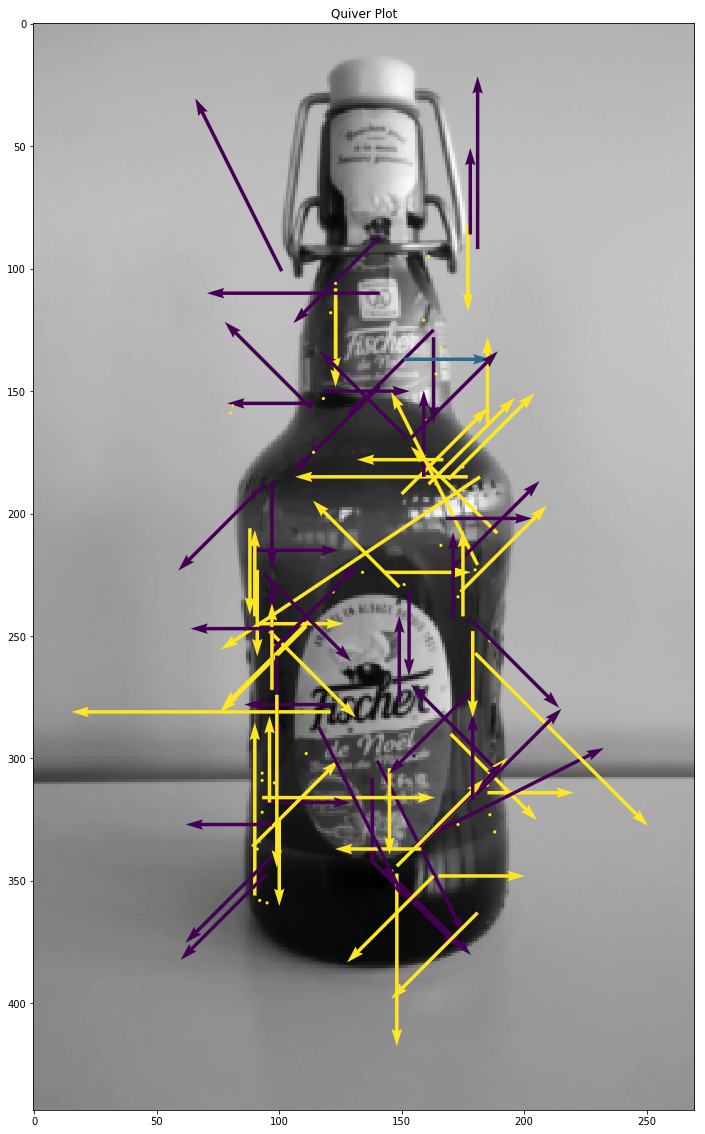

In [127]:
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(scaled_imgs[0.25],cmap='gray')
ax.quiver(yextr, xextr, dyextr, dxextr, maskextr, color='r',norm=None,scale=0.015)

ax.set(aspect=1, title='Quiver Plot')
plt.show()

(array([49.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0., 79.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

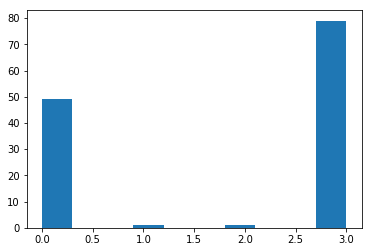

In [128]:
plt.hist(maskextr)